# FRET analysis - ratiometric

This is a script to analyze FRET in 2D confocal images of cells transfected with different force sensors.
As controls, we use a donor only and acceptor only construct.

All images were acquired on SP8 confocal microscope.
Laser % and detector gains were kept at constant ratios to make sure that donor leakage and acceptor direct excitation are correctly calibrated.

This script is meant to analyze files in an automatic way (nuclei segmentation, mask detection for the NE area, fluorescence intensity measurements in different channels, formatting of data, graphical representation...

## Workflow

1. open lif files
2. segment on DAPI - find bounding box
3. sum D and A channels => create a mask on the NE
4. run quality control (expressing / non transfected cell, removal of saturating cells)
5. measure fluorescence intensity in all channels (Donor, FRET, Acceptor)
6. save data along with metadata



This will already be a good start...

----

## Import libraries


In [44]:
from readlif.reader import LifFile
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import skimage.filters
from skimage.io import imread, imshow
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
#from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.aperture import CircularAperture
from scipy import ndimage
from astropy.stats import sigma_clipped_stats
#from photutils.datasets import load_star_image
import os
from scipy.spatial.distance import canberra
from scipy.spatial.distance import pdist
import math
from itertools import combinations

---

## Define folders and load data


In [45]:
# Define folders

InputFolder = '/Users/christine/Documents/Data/DynamoLINC/SP8/220331/'



()
9


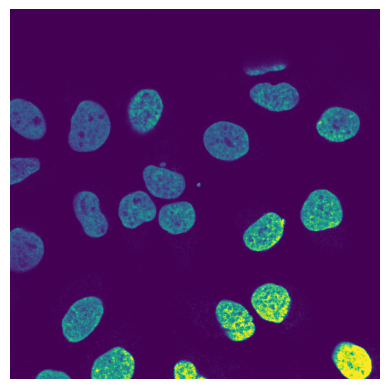

In [46]:
# open lif file

filename = '3-3.lif'
data = LifFile(InputFolder+filename)  # data is a LifFile object

data_im=np.array(data)
print(data_im.shape)

# open a single image (here the fourth in the file)
img_3 = data.get_image(3)
img_4 = data.get_image(4)

# create a list of images contained in the file
img_list = [i for i in data.get_iter_image()]  # img is a LifImage object
n=len(img_list)
print(n)

# access the different channels
img_4_DAPI = img_4.get_frame(c=0)
img_3_D = img_3.get_frame(c=1)
img_3_FRET = img_3.get_frame(c=2)
img_3_A = img_3.get_frame(c=3)

# from the list
for i in range(0,n):
    img_DAPI = img_list[i].get_frame(c=0)
    img_D = img_list[i].get_frame(c=1)
    img_FRET = img_list[i].get_frame(c=2)
    img_A = img_list[i].get_frame(c=3)
    
fig, ax = plt.subplots()
plt.imshow(img_4_DAPI)
plt.axis('off')
plt.show()


---

## Thresholding

We want to segment the nuclei by thresholding.

1. denoise
2. threshold
3. binarize
4. label image using connected components

To automatically calculate the threshold, we use Otsu's method.
https://datacarpentry.org/image-processing/07-thresholding/index.html




number of nuclei:  23


/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_12385/2903801951.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  filtered_DAPI = ndimage.filters.gaussian_filter(img_4_DAPI, sigma=1.5)


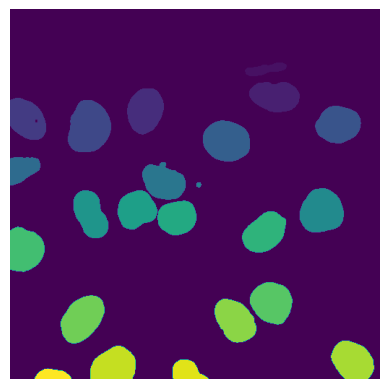

In [47]:
import skimage.measure

# denoise
filtered_DAPI = ndimage.filters.gaussian_filter(img_4_DAPI, sigma=1.5)
# binarize
t = skimage.filters.threshold_otsu(filtered_DAPI)
mask = filtered_DAPI>t-40

labeled_DAPI, count = skimage.measure.label(mask, connectivity=2,return_num=True)
print('number of nuclei: ',count)

fig, ax = plt.subplots()
plt.imshow(labeled_DAPI)
plt.axis('off')
plt.show()



---

## Bounding boxes

In order to reduce computing for the following steps, we need to define the bounding boxes / or define ROI for each nucleus.

As we have significantly decreased the threshold, the masks are wider thant the original nuclei and should include the whole NE region (hopefully).

To get the bounding boxes we use the skimage **regionprops** function (**properties=('bbox')**)
        => This returns a tuple **(min_row, min_col, max_row, max_col)**.

The bounding box is then defined as the ROI with pixels belonging to [min_row; max_row] and [min_col; max_col]





In [48]:
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd



props = regionprops_table(labeled_DAPI)
regions=pd.DataFrame(props)



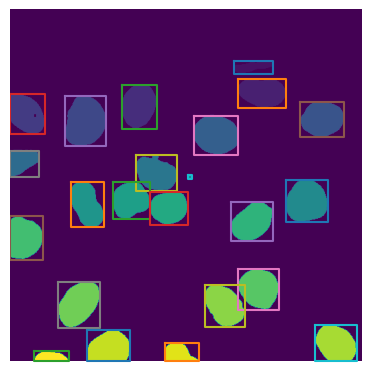

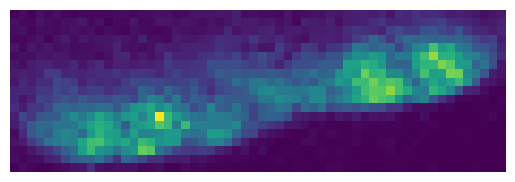

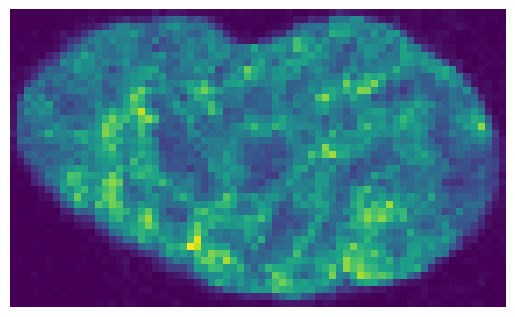

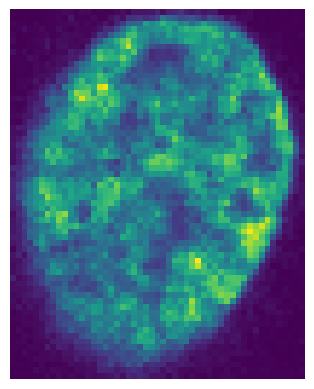

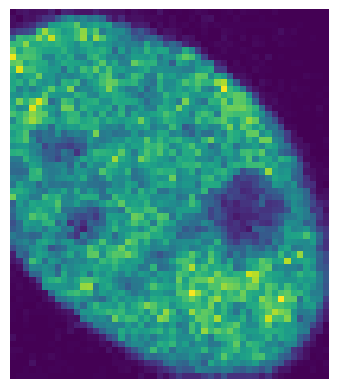

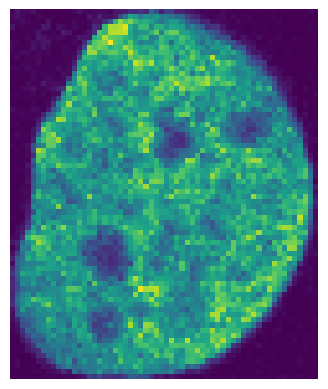

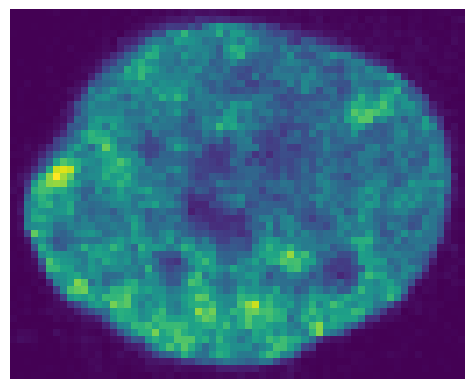

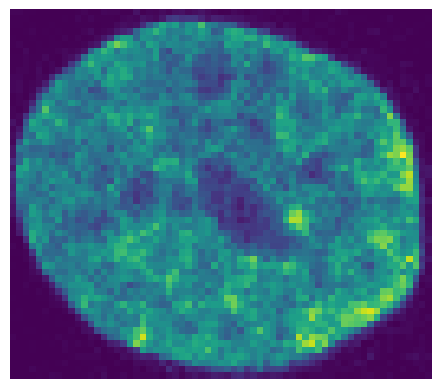

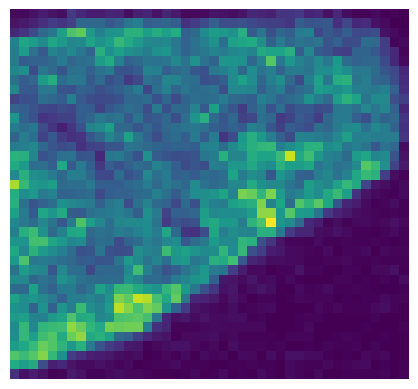

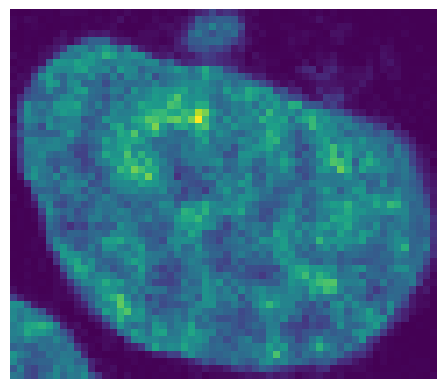

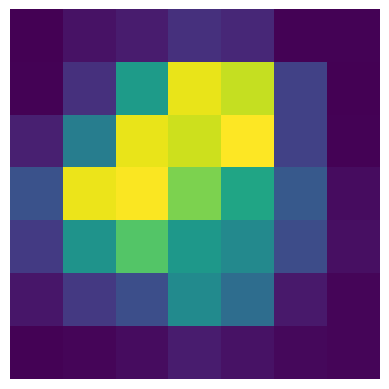

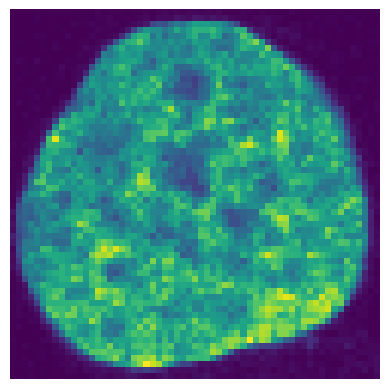

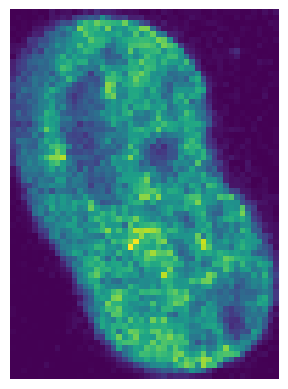

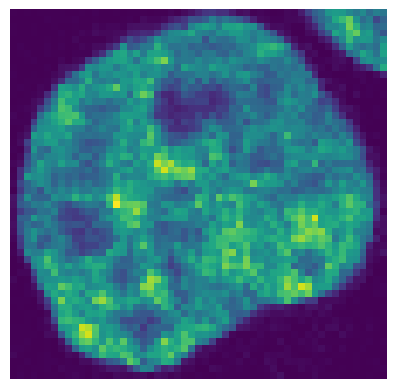

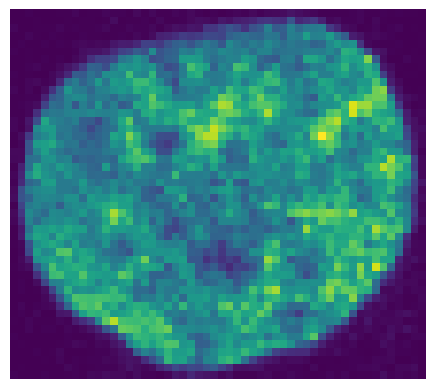

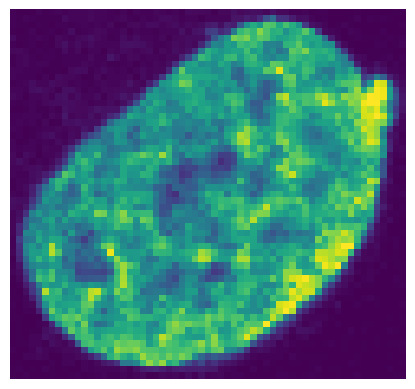

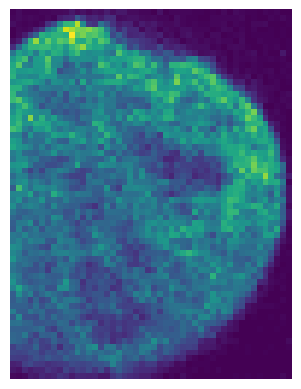

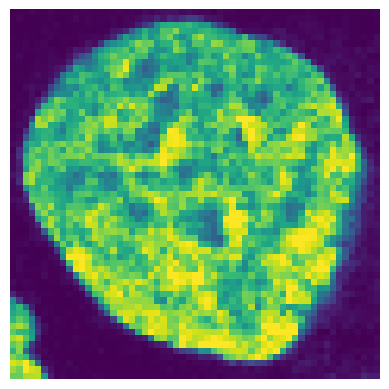

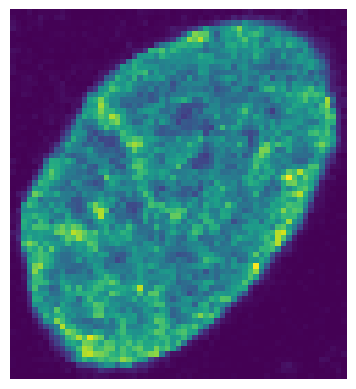

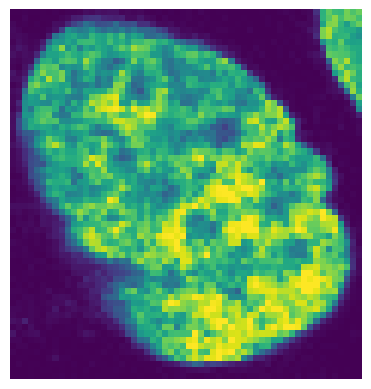

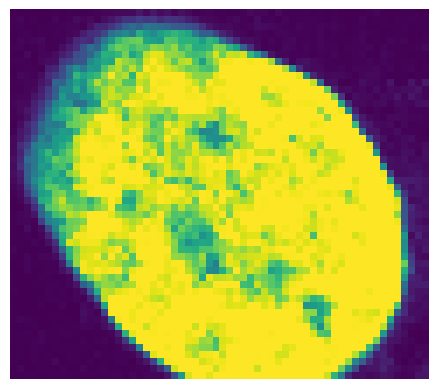

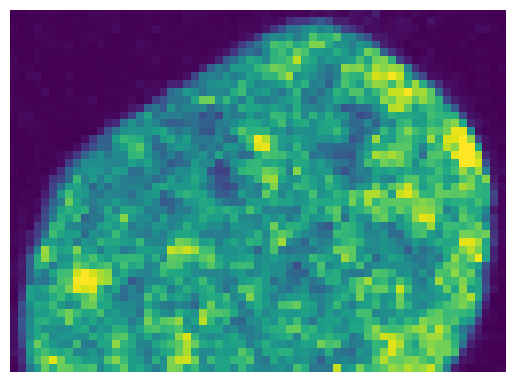

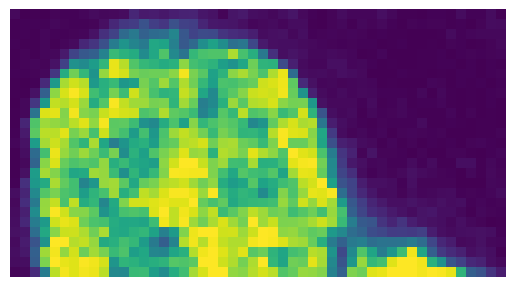

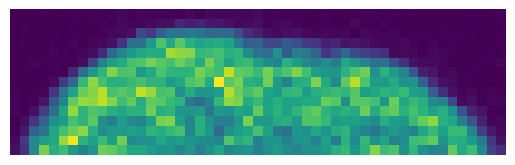

In [64]:
im = np.array(img_4_DAPI)

fig, ax = plt.subplots()
plt.imshow(labeled_DAPI)
plt.axis('off')

# store the bounding boxes coordinates in an array called ROIs (size = count x 4)
ROIs = np.zeros((count,4))
cc=0
for p in range(count):
    minx,miny,maxx,maxy = regions.iloc[p,1:5]
    
    
    bx=(miny,maxy,maxy,miny,miny)
    by=(minx,minx,maxx,maxx,minx)
    ROIs[cc] = minx,maxx,miny,maxy
    ax.plot(bx,by)
    
    
    ROI = im[minx:maxx,miny:maxy]
    cc=cc+1
plt.show()


for r in ROIs:
    minx,maxx,miny,maxy = r.astype(int)
    
    ROI = im[minx:maxx,miny:maxy]
    plt.imshow(ROI)
    plt.axis('off')
    plt.show()
    

---

## Selection of transfected nuclei

We will sum the donor and acceptor channels and select **only the nuclei that are transfected**. 

We also want to remove very tiny particles (with **maxx-minx or maxy-miny ≤ 15**).

The corresponding ROIs are then stored in a new array (**sorted_ROIs**)



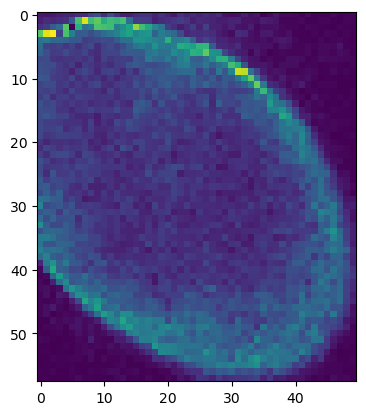

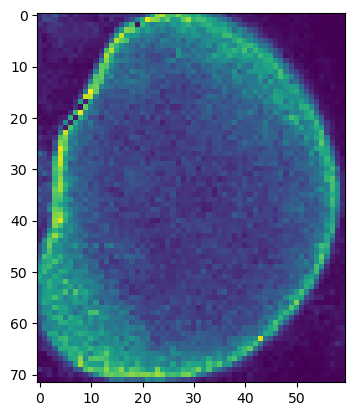

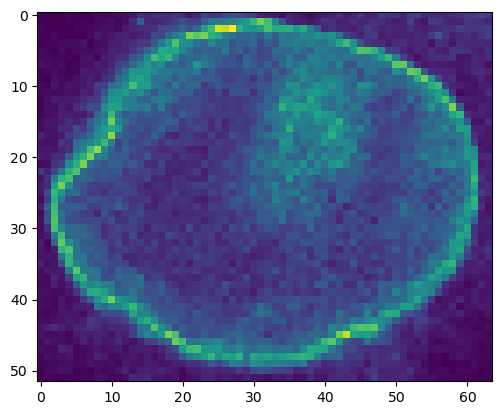

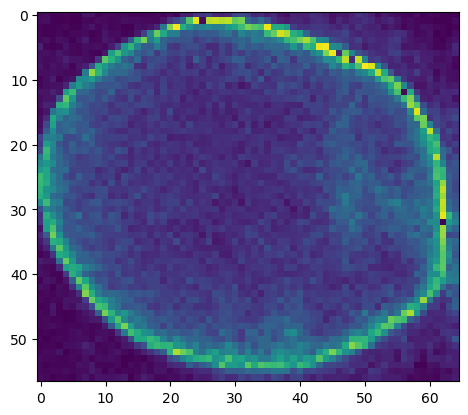

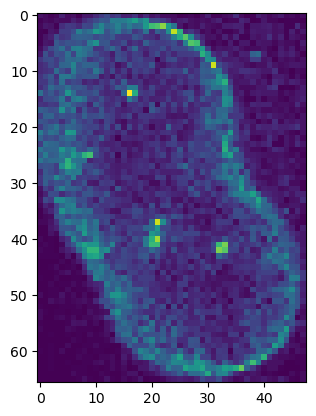

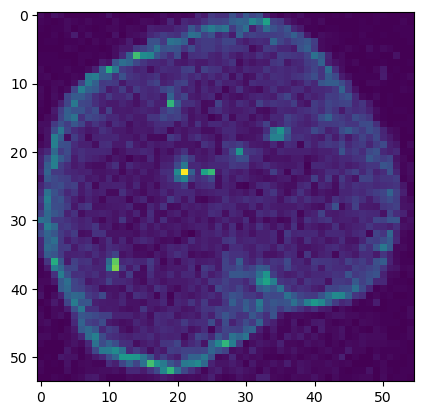

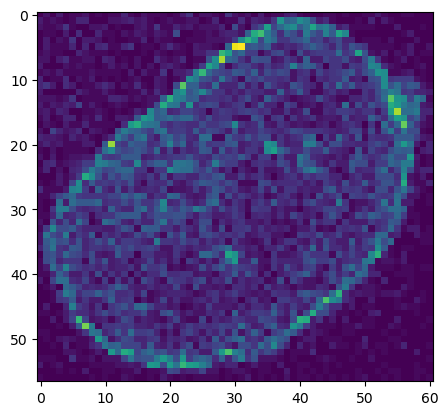

(23, 4)
(20, 4)
(7, 4)


In [67]:
# Create a SUM image with the donor and acceptor channel => sort out untransfected nuclei
imD = np.array(img_4.get_frame(c=1))  
imFRET = np.array(img_4.get_frame(c=2)) 
imA = np.array(img_4.get_frame(c=3))  
SUM = imD+imA

plt.imshow(SUM)

temp_array=[]
# remove tiny ROIs
for i in range(count):
    
    if ROIs[i,1]-ROIs[i,0]>20.0 and ROIs[i,3]-ROIs[i,2]>20.0:
        temp_array.append(ROIs[i,:])

sort1_ROIs=np.array(temp_array)
        
     
temp2=[]       
for i in range(len(sort1_ROIs)):
    [minx,maxx,miny,maxy]=sort1_ROIs[i,:].astype(int)
    ROI=SUM[minx:maxx,miny:maxy]
    if np.std(ROI)>5:
        temp2.append(sort1_ROIs[i,:])
        plt.imshow(ROI)
        plt.show()
    
sorted_ROIs=np.array(temp2)
    
        
print(ROIs.shape)    
print(sort1_ROIs.shape)
print(sorted_ROIs.shape)



---

## NE detection and intensity measurements




/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_12385/2788779960.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  filtered_ROI = ndimage.filters.gaussian_filter(ROI, sigma=1)


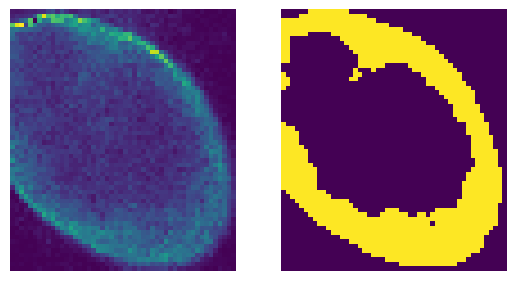

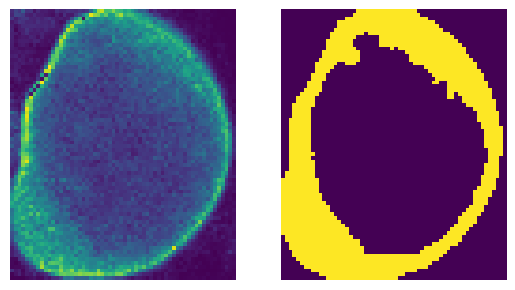

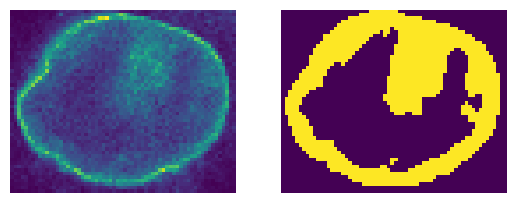

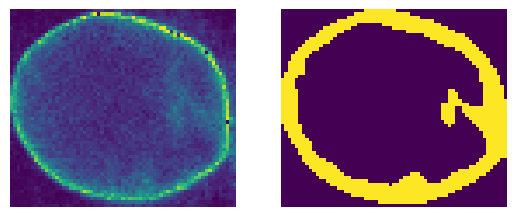

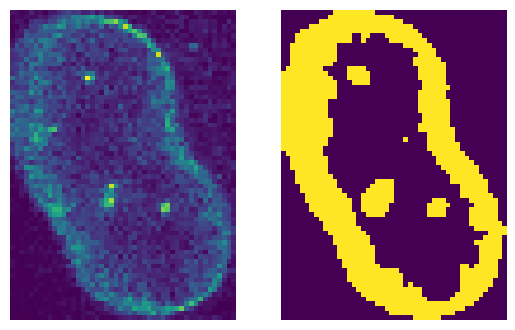

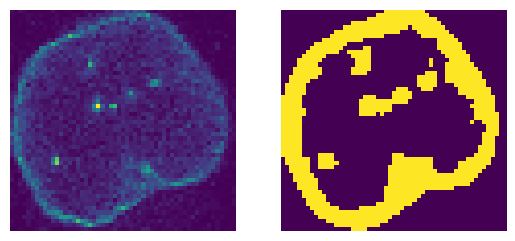

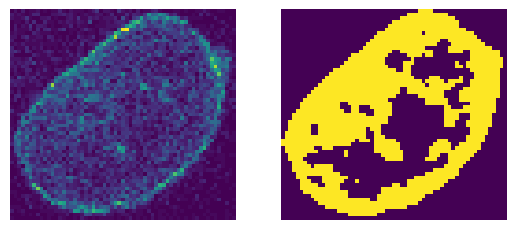

In [68]:
# for each ROI, creation of a mask on the SUM image

df=pd.DataFrame(columns=(['Filename'],['Series'],['# nucleus'],['Bbox'],['NE area (px)'],['Donor'],['FRET'],['Acceptor']))
df.shape


for j in range(len(sorted_ROIs)):
    [minx,maxx,miny,maxy]=sorted_ROIs[j,:].astype(int)
    
    # work on SUM ROIs
    ROI=SUM[minx:maxx,miny:maxy]
    # denoise
    filtered_ROI = ndimage.filters.gaussian_filter(ROI, sigma=1)
    #plt.imshow(filtered_ROI)
    # binarize
    t = skimage.filters.threshold_otsu(filtered_ROI)
    mask = filtered_ROI>t
    
    # show masks
    fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2)
    ax0.imshow(ROI)
    ax1.imshow(mask)
    ax0.axis('off')
    ax1.axis('off')
    plt.show()

    #calculate areas
    #area_j = 
    

#results = append.df(filename,i,j,bb,area,Id,Ifret,Ia)